# Fine-Tuning DistilBERT for AG News Classification

### Objective
This notebook fine-tunes a pre-trained `distilbert-base-uncased` model for the task of text classification on the AG News dataset. The goal is to leverage transfer learning to achieve state-of-the-art performance.

### Key Steps:
1.  **Load Data:** Load the AG News dataset from local `.parquet` files.
2.  **Prepare Data:** Create a custom PyTorch `Dataset` using the DistilBERT tokenizer to format the data correctly.
3.  **Load Model:** Load the pre-trained `DistilBertForSequenceClassification` model from Hugging Face.
4.  **Fine-Tune:** Train the model for 3 epochs using the `AdamW` optimizer and a linear learning rate scheduler.
5.  **Evaluate:** Measure the final performance of the fine-tuned model on the held-out test set.

In [71]:
# !pip install torch==2.2.2 torchtext==0.17.2 nltk
# !pip install torchdata==0.7.1
# !pip install pyarrow
# !pip install transformers
# !pip install seaborn

In [103]:
import torch
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
MODEL_PATH = "distilbert_for_finetuning"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 3
NUM_CLASSES = 4

print(f"Using device: {DEVICE}")

Using device: cuda


## Tokenizer

In [101]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)

In [35]:
print("Special tokens:")
print(f"  [PAD]: {tokenizer.pad_token}")
print(f"  [CLS]: {tokenizer.cls_token}")
print(f"  [SEP]: {tokenizer.sep_token}")
print(f"  [UNK]: {tokenizer.unk_token}")
print(f"  [MASK]: {tokenizer.mask_token}")

Special tokens:
  [PAD]: [PAD]
  [CLS]: [CLS]
  [SEP]: [SEP]
  [UNK]: [UNK]
  [MASK]: [MASK]


In [36]:
print("Vocabulary size:", tokenizer.vocab_size)

vocab_items = list(tokenizer.get_vocab().items())
print("First 20 vocab items:", vocab_items[:20])

Vocabulary size: 30522
First 20 vocab items: [('meng', 27955), ('hostility', 18258), ('nunez', 28454), ('preacher', 14512), ('folding', 12745), ('unemployment', 12163), ('extensive', 4866), ('improve', 5335), ('seahawks', 21390), ('typed', 21189), ('museo', 19713), ('lids', 26122), ('knowles', 22815), ('favourite', 8837), ('##re', 2890), ('##boarding', 21172), ('fortified', 13313), ('2011', 2249), ('##龍', 30508), ('ants', 16111)]


In [40]:
sample_text = "Hello world! This is a test."
encoding = tokenizer(sample_text, max_length=20, padding='max_length')
print("Encoded input IDs:", encoding['input_ids'])
print("Attention mask:", encoding['attention_mask'])

Encoded input IDs: [101, 7592, 2088, 999, 2023, 2003, 1037, 3231, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [39]:
decoded_text = tokenizer.decode(encoding['input_ids'])
print("Decoded text:", decoded_text)

Decoded text: [CLS] hello world! this is a test. [SEP]


## DataLoaders

In [41]:
class AGNewsHuggingFaceDataset(Dataset):
    """
    A custom Dataset class to prepare AG News data for a Hugging Face model.
    """
    def __init__(self, df: pd.DataFrame, tokenizer, max_length=128):
        self.labels = df.iloc[:, 1].tolist()
        self.texts = df.iloc[:, 0].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text. This returns a dictionary containing:
        # - input_ids: The numerical IDs for each token.
        # - attention_mask: A mask to tell the model which tokens to pay attention to.
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [42]:
def train_epoch_hf(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Move the entire batch dictionary to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # The model takes the batch dictionary directly
        outputs = model(**batch)
        loss = outputs.loss
        
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        progress_bar.set_postfix(loss=f'{loss.item():.4f}')
        
    return total_loss / len(dataloader)

In [43]:
def evaluate_epoch_hf(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += torch.sum(predictions == batch['labels'])

    return correct_predictions.double() / len(dataloader.dataset), total_loss / len(dataloader)

In [44]:
train_df = pd.read_parquet("ag_news/train.parquet")
test_df = pd.read_parquet("ag_news/test.parquet")

train_dataset_full = AGNewsHuggingFaceDataset(train_df, tokenizer)
test_dataset = AGNewsHuggingFaceDataset(test_df, tokenizer)

In [45]:
num_train = int(len(train_dataset_full) * 0.92)
split_train, split_valid = random_split(
    train_dataset_full, [num_train, len(train_dataset_full) - num_train]
)

In [46]:
# DataLoaders
train_dataloader = DataLoader(split_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(split_valid, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Fine Tuning

In [55]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_CLASSES,
    local_files_only=True
).to(DEVICE)

In [56]:
sample_text = "This is a test."
encoding = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)

with torch.no_grad():
    outputs = model(**encoding)

print("Logits:", outputs.logits)
print("Predicted class:", torch.argmax(outputs.logits, dim=-1).item())

Logits: tensor([[-0.1165, -0.0059, -0.0244,  0.0833]], device='cuda:0')
Predicted class: 3


In [57]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 66956548
Trainable parameters: 66956548


In [58]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
num_training_steps = EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)    

# --- Fine-Tuning Loop ---

In [59]:
best_accuracy = 0

In [61]:
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    
    train_loss = train_epoch_hf(model, train_dataloader, optimizer, lr_scheduler, DEVICE)
    val_acc, val_loss = evaluate_epoch_hf(model, valid_dataloader, DEVICE)    
    print(f"\nEpoch Summary:")
    print(f"\tTrain Loss: {train_loss:.4f}")
    print(f"\tValid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        model.save_pretrained("./distilbert_finetuned_agnews")
        tokenizer.save_pretrained("./distilbert_finetuned_agnews")
        print("New best model saved!")


--- Epoch 1/3 ---




Epoch Summary:
	Train Loss: 0.2214
	Valid Loss: 0.1767 | Valid Acc: 93.92%
New best model saved!

--- Epoch 2/3 ---




Epoch Summary:
	Train Loss: 0.1187
	Valid Loss: 0.1706 | Valid Acc: 94.59%
New best model saved!

--- Epoch 3/3 ---




Epoch Summary:
	Train Loss: 0.0623
	Valid Loss: 0.1882 | Valid Acc: 94.54%


In [63]:
print("\n--- Running Final Evaluation ---")

final_model = DistilBertForSequenceClassification.from_pretrained("./distilbert_finetuned_agnews").to(DEVICE)
val_acc, val_loss = evaluate_epoch_hf(final_model, valid_dataloader, DEVICE)
test_acc, test_loss = evaluate_epoch_hf(final_model, test_dataloader, DEVICE)

print('=' * 50)
print(f"\nFinal Validation Results:")
print(f"\Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc*100:.2f}%")
print('=' * 50)
print(f"\nFinal Test Results:")
print(f"\tTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")


--- Running Final Evaluation ---




Final Validation Results:
\Validation Loss: 0.1706 | Validation Accuracy: 94.59%

Final Test Results:
	Test Loss: 0.1669 | Test Accuracy: 94.79%


In [90]:
custom_model_results_df = pd.read_csv("final_evaluation_summary.csv")
custom_model_results_df

,Experiment,Val Loss,Val Accuracy (%),Test Loss,Test Accuracy (%)
0,EXP_1_SGD,0.4418,86.15,0.6252,77.22
1,EXP_2_Adam_51_70,0.4237,86.31,0.4669,85.45
2,EXP_3_Adam_71_100,0.2817,91.32,0.3723,89.64
3,EXP_4_Adam_101_120,0.2537,91.92,0.3434,89.97
4,EXP_5_Adam_121_140,0.2352,92.62,0.3470,90.13
5,EXP_6_Adam_141_160,0.2152,93.09,0.3405,90.32


In [91]:
best_custom_model_val_acc = custom_model_results_df.iloc[-1]['Val Accuracy (%)']
best_custom_model_val_acc

93.09

In [92]:
best_custom_model_test_acc = custom_model_results_df.iloc[-1]['Test Accuracy (%)']
best_custom_model_test_acc

90.32

In [93]:
finetuned_distilbert_val_acc = 94.59
finetuned_distilbert_test_acc = 94.79

In [94]:
comparison_data = [
    {
        'Model': 'Custom Transformer\n(Trained from Scratch)',
        'Validation Accuracy (%)': best_custom_model_val_acc,
        'Test Accuracy (%)': best_custom_model_test_acc
    },
    {
        'Model': 'DistilBERT\n(Fine-Tuned)',
        'Validation Accuracy (%)': finetuned_distilbert_val_acc,
        'Test Accuracy (%)': finetuned_distilbert_test_acc
    }
]
results_df = pd.DataFrame(comparison_data)
results_df

,Model,Validation Accuracy (%),Test Accuracy (%)
0,Custom Transformer\n(Trained from Scratch),93.09,90.32
1,DistilBERT\n(Fine-Tuned),94.59,94.79


In [95]:
plot_df = results_df.melt(
    id_vars='Model', 
    value_vars=['Validation Accuracy (%)', 'Test Accuracy (%)'],
    var_name='Metric', 
    value_name='Accuracy'
)

In [96]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 8))

bar_plot = sns.barplot(
    x='Accuracy', 
    y='Model', 
    hue='Metric',
    data=plot_df, 
    palette='viridis', 
    orient='h'
)

Final comparison plot saved to 'final_model_comparison_detailed.png'


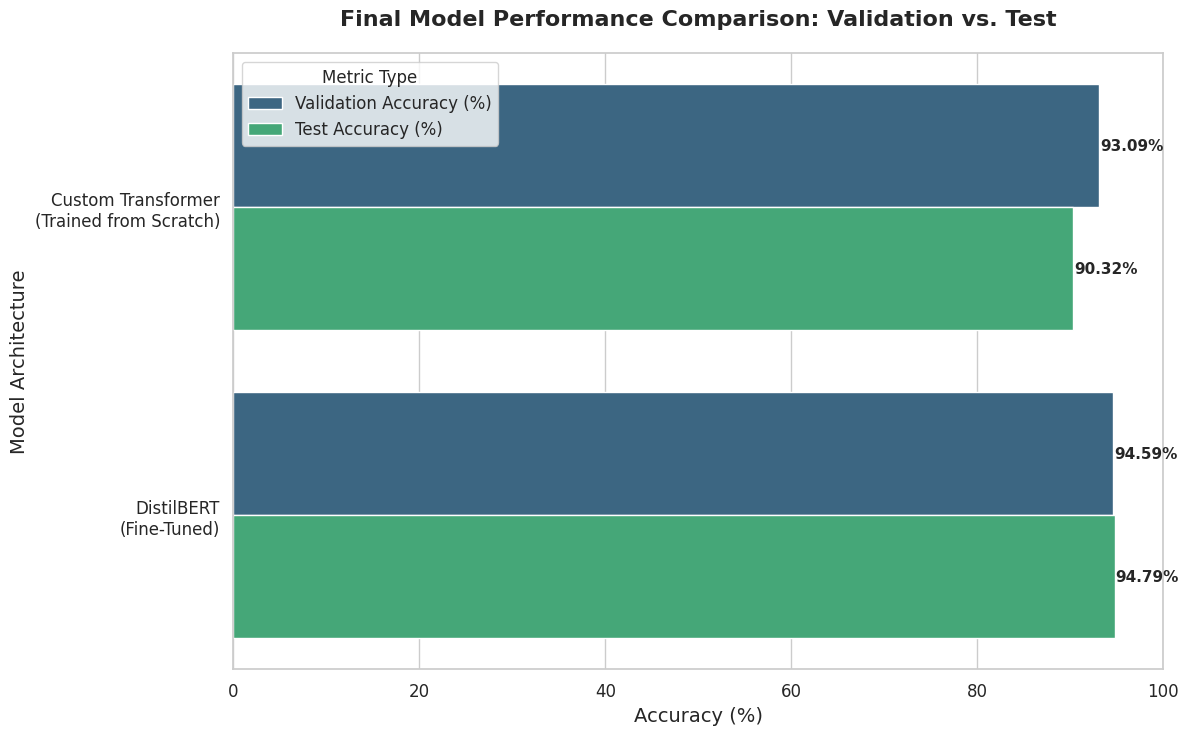

In [97]:
for p in bar_plot.patches:
    width = p.get_width()
    if width > 0:
        bar_plot.text(width + 0.1, p.get_y() + p.get_height() / 2,
                      f'{width:.2f}%', ha='left', va='center', fontsize=11, weight='bold')

plt.title('Final Model Performance Comparison: Validation vs. Test', fontsize=16, weight='bold', pad=20)
plt.xlabel('Accuracy (%)', fontsize=14)
plt.ylabel('Model Architecture', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(
    title='Metric Type',
    fontsize=12,
    loc='upper left'
)

plt.xlim(0, 100)

output_path = 'final_model_comparison_detailed.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"Final comparison plot saved to '{output_path}'")
plt.show()

## Prediction

In [104]:
import random

MODEL_PATH = "./distilbert_finetuned_agnews" 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, local_files_only=True).to(DEVICE)
    model.eval()
    print("Fine-tuned model and tokenizer loaded successfully.")
except OSError:
    print(f"Error: Could not find model files at '{MODEL_PATH}'. Please check the path.")
    exit()

test_df = pd.read_parquet("ag_news/test.parquet")

id_to_label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tec"}


def predict(text: str, model, tokenizer, device, id_to_label_map):
    """
    Takes a text string and returns the predicted class label.
    """
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt", # Return PyTorch tensors
        truncation=True,
        padding=True,
        max_length=128
    )

    # Move tokenized inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference
    with torch.no_grad():     
        outputs = model(**inputs)
        logits = outputs.logits

    predicted_class_id = torch.argmax(logits, dim=1).item()
    
    return id_to_label_map[predicted_class_id]

Using device: cuda
Fine-tuned model and tokenizer loaded successfully.


In [106]:
random_samples = test_df.sample(n=20)
    
print("\n---Running Predictions on 20 Random Samples ---")
    
for index, row in random_samples.iterrows():
    text_sample = row.iloc[0]
    true_label_id = row.iloc[1]
        
    true_label_name = id_to_label[true_label_id]
        
    predicted_label = predict(text_sample, model, tokenizer, DEVICE, id_to_label)
        
    print(f"\nTEXT: {text_sample[:100]}...")
    print(f"   -> TRUE LABEL:     {true_label_name}")
    print(f"   -> PREDICTED LABEL: {predicted_label}")
    print("=" * 100)


---Running Predictions on 20 Random Samples ---

TEXT: Melrose comes up short Melrose entered its Thanksgiving Day matchup with Wakefield as an undefeated ...
   -> TRUE LABEL:     Sports
   -> PREDICTED LABEL: Sports

TEXT: Study: Apple, Dell lead PC customer satisfaction index The PC industry is doing a better job this ye...
   -> TRUE LABEL:     Sci/Tec
   -> PREDICTED LABEL: Sci/Tec

TEXT: A So-So Debut For Microsoft #39;s Blog Service Microsoft Corp. made a belated entrance into the  quo...
   -> TRUE LABEL:     Sci/Tec
   -> PREDICTED LABEL: Sci/Tec

TEXT: Button decision delayed Jenson Button must wait until next month before discovering which Formula On...
   -> TRUE LABEL:     Sports
   -> PREDICTED LABEL: Sports

TEXT: King's Widow Turns Focus on Voting Rights (AP) AP - The widow of Martin Luther King Jr. said the rig...
   -> TRUE LABEL:     World
   -> PREDICTED LABEL: World

TEXT: Delta gets tentative deal with pilots After 15 months of negotiations, Delta Air Lines Inc. 